<a target="_blank" href="https://colab.research.google.com/github/PDBeurope/pdbe-notebooks/blob/main/pdbeccdutils_tutorials/spring_school_cadd/pdbeccdutils.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

PDBe CCDUtils is an open-source python package for processing and analyzing small molecules in the PDB. Small-molecule data in the PDB is available as [Chemical Component Dictionary (CCD)](http://www.wwpdb.org/data/ccd) or [Biologically Interesting Molecule reference Dictioanry (BIRD)](http://www.wwpdb.org/data/bird) in PDBX/mmCIF format. PDBe CCDUtils provides streamlined access to all metadata of small molecules in the PDB and offers a set of convenient methods to compute various properties using RDKIt such as 

* [Physicochemical properties](#accessing-properties-of-CCD)
* [Matching common fragments and scaffolds](#finding-fragments-and-scaffolds)
* [Mapping to small-molecule databases using UniChem](#fetching-external-mappings-to-other-databases)
* [2D depictions](#2D-Depictions)
* [Similarity using PARITY method](#similarity-using-parity-method)
* [Export to multiple formats](#export-to-different-formats)
 

PDBe CCDUtils also provides methods for identifying all the Covalently Linked Chemical components (CLC) in a macromolecular structure. To findout more, please refer to the publication [PDBe CCDUtils: an RDKit-based toolkit for handling and analysing small molecules in the Protein Data Bank](https://doi.org/10.1186/s13321-023-00786-w)

## Installation of dependencies

In [3]:
# %pip install rdkit pdbeccdutils wget

## Helper functions

In [4]:
import os
import gzip
import requests
from enum import Enum
from typing import NamedTuple
import pandas as pd
from collections import defaultdict
from typing import List, Set, Dict
from gemmi import cif
from pdbeccdutils.core.component import Component

In [5]:
PDBECHEM_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2"
ENTRY_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/updated_mmcif/all"

class ligandType(Enum):
    CCD = "ccd"
    PRD = "prd"
    CLC = "clc"

class Subcomponent(NamedTuple):
    id: int
    name: str
    atoms: list[str]


def get_ligand_cif(ligand_id: str, ligand_type: ligandType) -> str:
    """
    Downloads and writes ligand CIF from PDBe FTP to a file
    and returns the path

    Args:
        ligand_id: ID of the ligand
        ligand_type: Type of ligand
    
    Returns:
        The path to cif file of ligand
    """
    match ligand_type.value:
        case "ccd":
            ligand_dir = os.path.join("ccd", ligand_id[0], ligand_id)
        case "prd":
            ligand_dir = os.path.join("prd", ligand_id[-1],ligand_id)
        case "clc":
            ligand_dir = os.path.join("clc", ligand_id[-1],ligand_id)
    try:
        ligand_cif_path = os.path.join(PDBECHEM_URL, ligand_dir, f"{ligand_id}.cif")
        response = requests.get(ligand_cif_path)
        assert response.status_code == 200
        ligand_cif_file = os.path.join(os.getcwd(), f"{ligand_id}.cif")
        with open(ligand_cif_file, "wb") as fh:
            fh.write(response.content)

        return ligand_cif_file
    except  AssertionError:
        print(f"Couldn't find the file. Check if {ligand_id} & {ligand_type} are valid, if so try again")


def get_entry_cif(pdb_id: str) -> str:
    """
    Downloads and writes PDB entry updated mmCIF to a file and 
    returns the path

    Args:
        pdb_id: PDB id of an entry

    Returns:
        path to the downloaded file
    """
    entry_url = os.path.join(ENTRY_URL, f"{pdb_id}_updated.cif.gz")
    response = requests.get(entry_url, stream=True)
    response.raise_for_status()
    with open(f"{pdb_id}_updated.cif", "wb") as fh:
        fh.write(gzip.decompress(response.content))

    return f"{pdb_id}_updated.cif"


def get_subcomponents(component: Component) -> List[Subcomponent]:
    """
    Returns a list of subcomponents present in a 
    multi-component ligand

    Args:
        component: Component object of small molecule
    """
    mol = component.mol_no_h
    atoms = defaultdict(list)
    for atom in mol.GetAtoms():
        if not atom.HasProp("residue_id"):
            continue
        else:
            res_id = atom.GetProp("residue_id")
            res_info = atom.GetPDBResidueInfo()
            res_name = res_info.GetResidueName()
            atoms[(res_id, res_name)].append(atom.GetProp("name"))
        
    subcomponents = [Subcomponent(id=key[0],
                                  name = key[1],
                                  atoms = values,
                                ) for key, values in atoms.items()]
    return subcomponents


## Reading small molecule data

In [6]:
from pdbeccdutils.core import ccd_reader

In [7]:
hem_cif = get_ligand_cif("HEM", ligandType.CCD)
hem =  ccd_reader.read_pdb_cif_file(hem_cif)
hem

CCDReaderResult(warnings=[], errors=[], component=<pdbeccdutils.core.component.Component object at 0x7fc8d18cdba0>, sanitized=True)

CCDReaderResult contains a component object - the core structural representation of small-molecules in PDBe CCDUtils. Component is a wrapper around rdkit.Chem.rdchem.Mol object providing most of its functionality and access metada data from CCD file. 

In [8]:
hem_component = hem.component

## Accessing properties of CCD

Properties in the CCD file and physicochemical properties generated by RDKit can be accessed using attributes of the Component object

In [9]:
print(f"""
id: {hem_component.id}
name: {hem_component.name}
formula: {hem_component.formula}
inchi: {hem_component.inchi}
inchikey: {hem_component.inchikey}
release status: {hem_component.pdbx_release_status.name}
modified_date: {hem_component.modified_date}
""")


id: HEM
name: PROTOPORPHYRIN IX CONTAINING FE
formula: C34 H32 Fe N4 O4
inchi: InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;
inchikey: KABFMIBPWCXCRK-RGGAHWMASA-L
release status: REL
modified_date: 2020-06-17



In [10]:
hem_component.descriptors

[Descriptor(type='SMILES', program='ACDLabs', program_version='12.01', value='C=1c3c(c(c4C=C5C(=C(C=6C=C7C(=C(C8=CC=2C(=C(C=1N=2[Fe](n34)(N5=6)N78)CCC(=O)O)C)\\C=C)C)\\C=C)C)C)CCC(=O)O'),
 Descriptor(type='InChI', program='InChI', program_version='1.03', value='InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;'),
 Descriptor(type='InChIKey', program='InChI', program_version='1.03', value='KABFMIBPWCXCRK-RGGAHWMASA-L'),
 Descriptor(type='SMILES_CANONICAL', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C)c(C)c7C=C'),
 Descriptor(type='SMILES', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C

In [11]:
hem_component.physchem_properties

{'exactmw': 616.177293004001,
 'amw': 616.4990000000015,
 'lipinskiHBA': 8.0,
 'lipinskiHBD': 2.0,
 'NumRotatableBonds': 12.0,
 'NumHBD': 2.0,
 'NumHBA': 8.0,
 'NumHeavyAtoms': 43.0,
 'NumAtoms': 75.0,
 'NumHeteroatoms': 9.0,
 'NumAmideBonds': 0.0,
 'FractionCSP3': 0.23529411764705882,
 'NumRings': 6.0,
 'NumAromaticRings': 2.0,
 'NumAliphaticRings': 4.0,
 'NumSaturatedRings': 0.0,
 'NumHeterocycles': 6.0,
 'NumAromaticHeterocycles': 2.0,
 'NumSaturatedHeterocycles': 0.0,
 'NumAliphaticHeterocycles': 4.0,
 'NumSpiroAtoms': 0.0,
 'NumBridgeheadAtoms': 6.0,
 'NumAtomStereoCenters': 1.0,
 'NumUnspecifiedAtomStereoCenters': 0.0,
 'labuteASA': 296.33725284003606,
 'tpsa': 96.26000000000002,
 'CrippenClogP': 6.210060000000007,
 'CrippenMR': 165.27259999999967,
 'chi0v': 21.879585517566603,
 'chi1v': 13.71303192500862,
 'chi2v': 11.67144422171997,
 'chi3v': 11.67144422171997,
 'chi4v': 10.931337280412357,
 'chi0n': 52.775400934448555,
 'chi1n': 27.554303075888956,
 'chi2n': 7.046175792189254,

## Fetching external mappings to other databases

In [12]:
external_mappings = hem_component.fetch_external_mappings(all_mappings=True)
external_mappings

[('BRENDA', '228486'),
 ('MedChemExpress', 'HY-111914A'),
 ('BRENDA', '228485'),
 ('BRENDA', '135197'),
 ('PDBe', 'HEM'),
 ('SureChEMBL', 'SCHEMBL4008'),
 ('ChEBI', '17627'),
 ('DrugBank', 'DB18267'),
 ('ChEBI', '26355'),
 ('fdasrs', '42VZT0U6YR'),
 ('PubChem TPHARMA', '14912106'),
 ('Probes And Drugs', 'PD158908'),
 ('BRENDA', '1517'),
 ('BRENDA', '8254'),
 ('BRENDA', '143348'),
 ('BRENDA', '822'),
 ('BRENDA', '211503'),
 ('BRENDA', '144129'),
 ('MetaboLights', 'MTBLC26355'),
 ('MetaboLights', 'MTBLC17627'),
 ('BRENDA', '3360'),
 ('BRENDA', '30062'),
 ('BRENDA', '48'),
 ('EPA CompTox Dashboard', 'DTXSID90889386'),
 ('HMDB', 'HMDB0003178')]

## Finding fragments

PDBe CCDUtils supports search for fragments present in a small molecule from a library of fragments. The fragment library present in PDBe CCDUtils contains 2158 fragments which were manually currated at PDBe and collaborating resources (ENAMINE, DSI). Should you wish to check all the fragments, please check [fragment_library.tsv](https://github.com/PDBeurope/ccdutils/blob/master/pdbeccdutils/data/fragment_library.tsv) file.

In [13]:
from pdbeccdutils.core.fragment_library import FragmentLibrary
from rdkit.Chem import Draw

In [14]:
fragment_library = FragmentLibrary()

In [15]:
fragment_matches = hem_component.library_search(fragment_library)
print(f"No of fragments found: {len(fragment_matches)}")

No of fragments found: 2


In [16]:
fragment_matches

[SubstructureMapping(name='porphin-like', mol=<rdkit.Chem.rdchem.Mol object at 0x7fc8d192c040>, source='PDBe', mappings=((5, 6, 7, 1, 14, 39, 17, 16, 15, 2, 21, 40, 24, 3, 28, 41, 31, 0, 4, 38, 30, 29, 23, 22),)),
 SubstructureMapping(name='pyrrole', mol=<rdkit.Chem.rdchem.Mol object at 0x7fc8d192c7b0>, source='PDBe', mappings=((4, 5, 6, 7, 38), (21, 22, 23, 24, 40)))]

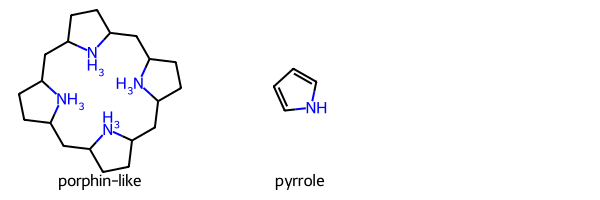

In [17]:
fragment_mols = [fragment.mol for fragment in hem_component.fragments]
img = Draw.MolsToGridImage(fragment_mols, legends = [fragment.name for fragment in hem_component.fragments])
img

## Finding scaffolds

PDBe CCDUtils supports identification of scaffolds of small moelcules in PDB using the RDKit functionality. Currently it supports three types of scaffolding methods
* MurckoScaffold
* MurckoScaffoldGeneric
* BRICS

In [18]:
from pdbeccdutils.core.models import ScaffoldingMethod

In [19]:
murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoScaffold)
generic_murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoGeneric)
brics_scaffolds = hem_component.get_scaffolds(scaffolding_method=ScaffoldingMethod.Brics)

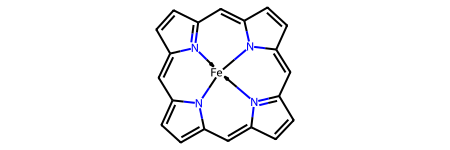

In [20]:
murcko_scaffolds[0]

## 2D Depictions

PDBe CCDUtils uses [template-based](https://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html#rdkit.Chem.rdDepictor.GenerateDepictionMatching2DStructure) and [connectivity based](https://rdkit.org/docs/source/rdkit.Chem.rdCoordGen.html) methods from RDKit to generate 2D depictions of small moelcules. Templates can either be downloaded from PubChem or provided as a path to a folder containing SDF files. A hand-curated set of [ten templates](https://github.com/PDBeurope/ccdutils/tree/master/pdbeccdutils/data/general_templates) are also provided with PDBe CCDUtils

To find the best depiction of a small molecule, a heuristic-based Depiction Penalty Score (DPS) is defined. A DPS of zero indicates a high-quality 2D depiction, while higher scores indicate lower quality.

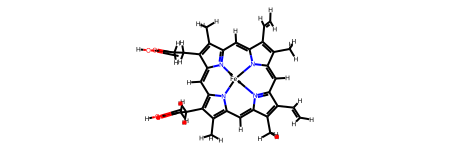

In [21]:
hem_component.mol

In [22]:
from pdbeccdutils.core.depictions import DepictionManager
from pdbeccdutils.utils.pubchem_downloader import PubChemDownloader
from IPython.core.display import SVG

In [23]:
pubchem_templates = os.getcwd()
pubchem_downloader = PubChemDownloader(pubchem_templates)

In [24]:
pubchem_downloader.process_template(hem_component)
depictions = DepictionManager(pubchem_templates)
depiction_result = hem_component.compute_2d(depictions)
depiction_result

[18:48:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


DepictionResult(source=<DepictionSource.Template: 2>, template_name='hem', mol=<rdkit.Chem.rdchem.RWMol object at 0x7fc8d1921120>, score=0.0)

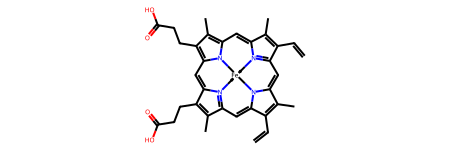

In [25]:
hem_component.mol2D

In [26]:
hem_component.export_2d_svg("hem.svg", width=400)

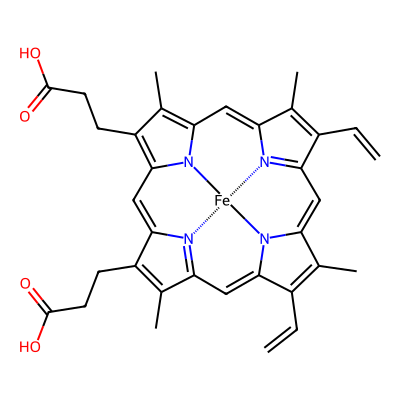

In [27]:
SVG("hem.svg")

### Highlighting substructures

Atoms and bonds of substructures (fragments and scaffolds) can be highligted on the 2D depiction of small molecules using *export_2d_svg* method of Component object. The atoms to highlight can be passed as a dictionary with atom names as keys and the color as values. Similarly the bonds to highlight can be passed as a dictionary of atom names of bonds as a tuple and colors as values.
The below example shows how to highlight the Murcko scaffold of **HEM**. 

In [28]:
atom_color = (0.5, 0.5, 0.5, 0.4)
bond_color = (0.5, 0.5, 0.5, 0.8)
hem_murcko_scaffold = murcko_scaffolds[0]
athighlights = {atom.GetProp("name"):atom_color for atom in hem_murcko_scaffold.GetAtoms()}
bndhighlights = {(bond.GetBeginAtom().GetProp("name"), bond.GetEndAtom().GetProp("name")): bond_color for bond in hem_murcko_scaffold.GetBonds()}
hem_component.export_2d_svg("hem_scaffold.svg", atom_highlight=athighlights, bond_highlight=bndhighlights, width=400)

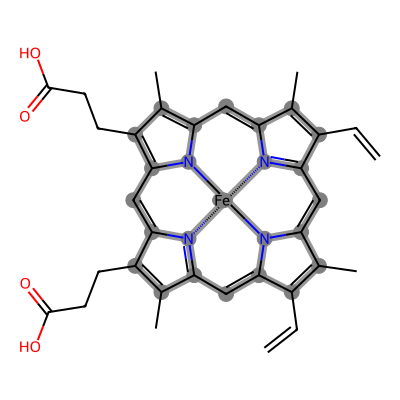

In [29]:
SVG("hem_scaffold.svg")

## Similarity using PARITY method

PDBe CCDUtils supports comparison of small moelcules based on [PARITY](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5890617/) similarity score. PARITY represents the proportion of atoms of same type residing in identical topology between two small molecules

In [30]:
from pdbeccdutils.computations.parity_method import compare_molecules

In [31]:
heme_acetyl_cif = get_ligand_cif("HCO", ligandType.CCD)
heme_acetyl_component = ccd_reader.read_pdb_cif_file(heme_acetyl_cif).component

In [32]:
similarity = compare_molecules(hem_component.mol_no_h, heme_acetyl_component.mol_no_h)

In [33]:
similarity

ParityResult(mapping={0: 1, 4: 9, 5: 10, 6: 11, 7: 12, 38: 5, 42: 0, 40: 7, 21: 27, 2: 3, 17: 22, 39: 6, 14: 19, 1: 2, 15: 20, 16: 21, 19: 24, 20: 25, 18: 23, 22: 28, 23: 29, 24: 30, 3: 4, 28: 34, 41: 8, 31: 37, 30: 36, 29: 35, 32: 38, 33: 39, 34: 40, 35: 41, 36: 42, 37: 43, 26: 32, 27: 33, 25: 31, 8: 13, 9: 14, 10: 15, 11: 16, 12: 17, 13: 18}, similarity_score=0.9772727272727273)

## Export to different formats

PDBe CCDUtils presently supports exporting of small molecule data to the following formats
* CIF
* PDB
* SDF
* CML

In [34]:
from pdbeccdutils.core import ccd_writer

In [35]:
ccd_writer.write_molecule("hem.sdf",
                          hem_component,
                          )

In [36]:
ccd_writer.write_molecule("hem.pdb",
                          hem_component,
                          )

# Use cases

## Fetching DrugBank details

The enriched CIF files of small molecules available from [PDBeChem FTP](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2) contains data fetched from DrugBank. This information can be accessed by parsing approriate category in the CIF files. The below example shows how to fetch DrugBank details of **IMATINIB** 

In [37]:
sti_cif = get_ligand_cif("STI", ligandType.CCD)
sti_component = ccd_reader.read_pdb_cif_file(sti_cif).component

In [38]:
def get_drugbank_synonyms(component: Component) -> Set[str]:
    """
    Returns synonyms from DrugBank

    Args:
        component: Component object of small molecule
    """

    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_synonyms." not in cif_block.get_mmcif_category_names():
        return
    synonyms = set()
    synonyms_table = cif_block.find("_pdbe_chem_comp_synonyms.", ["name", "provenance"])
    for row in synonyms_table:
        if row["_pdbe_chem_comp_synonyms.provenance"] == "DrugBank":
            synonyms.add(cif.as_string(row["_pdbe_chem_comp_synonyms.name"]))
    return synonyms

In [39]:
synonyms = get_drugbank_synonyms(sti_component)
synonyms

{'Celonib',
 'Enliven',
 'Imatib',
 'Imatinib',
 'Imatinibum',
 'Mesylonib',
 'Mitinab',
 'Plivatinib',
 'Shantinib',
 "α-(4-methyl-1-piperazinyl)-3'-((4-(3-pyridyl)-2-pyrimidinyl)amino)-p-toluidide"}

In [40]:
def get_drugbank_classification(component: Component) -> Dict[str, str]:
    """
    Returns DrugBank classification details

    Args:
        component: Component object of small molecule
    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_classification." not in cif_block.get_mmcif_category_names():
        return
    items = ["description", "kingdom", "superclass", "class", "parent"]
    classification = {item: cif.as_string(cif_block.find_value(f"_pdbe_chem_comp_drugbank_classification.{item}")) for item in items}
    return classification

In [41]:
get_drugbank_classification(sti_component)

{'description': "This compound belongs to the class of organic compounds known as benzanilides. These are aromatic compounds containing an anilide group in which the carboxamide group is substituted with a benzene ring. They have the general structure RNC(=O)R', where R,R'= benzene.",
 'kingdom': 'Organic compounds',
 'superclass': 'Benzenoids',
 'class': 'Benzene and substituted derivatives',
 'parent': 'Benzanilides'}

In [42]:
def get_drugbank_details(component: Component):
    """
    Returns details from DrugBank such as name, id, 
    description etc.

    Args:
        component: Component object of small molecule

    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_details." not in cif_block.get_mmcif_category_names():
        return
    items = ["drugbank_id", "name", "description", "mechanism_of_action"]
    details = defaultdict(list)
    for item in items:
        details["info"].append(item)
        details["value"].append(cif.as_string(cif_block.find_value(f"_pdbe_chem_comp_drugbank_details.{item}")))
    synonyms = get_drugbank_synonyms(component)
    details["info"].append("synonyms")
    details["value"].append(', '.join(synonyms))
    details_df = pd.DataFrame.from_dict(details)
    return details_df
    

In [43]:
pd.set_option('display.max_colwidth', None)
get_drugbank_details(sti_component)

,info,value
0,drugbank_id,DB00619
1,name,Imatinib
2,description,"Imatinib is a small molecule kinase inhibitor that revolutionized the treatment of cancer, particularly chronic myeloid leukemia, in 2001.[A249305] It was deemed a ""miracle drug"" due to its clinical success, as oncologist Dr. Brian noted that ""complete hematologic responses were observed in 53 of 54 patients with CML treated with a daily dosage of 300 mg or more and typically occurred in the first four weeks of therapy"".[A249315]. The discovery of imatinib also established a new group of therapy called ""targeted therapy"", since treatment can be tailored specifically to the unique cancer genetics of each patient.[L42220] Imatinib was approved on February 1st ,2001 by the FDA and November 7th, 2001 by the EMA; however, its European approval has been withdrawn in October 2023.[A263036,L49746,L49751]"
3,mechanism_of_action,"Imatinib mesylate is a protein-tyrosine kinase inhibitor that inhibits the BCR-ABL tyrosine kinase, the constitutively active tyrosine kinase created by the Philadelphia chromosome abnormality in CML.[L42080]Although the function of normal BCR is still unclear, ABL activation is overexpressed in various tumors and is heavily implicated in cancer cells growth and survival.[A249305,A249310] Imatinib inhibits the BCR-ABL protein by binding to the ATP pocket in the active site, thus preventing downstream phosphorylation of target protein.[A249305] Imatinib is also an inhibitor of the receptor tyrosine kinases for platelet-derived growth factor (PDGF) and stem cell factor (SCF), c-Kit, and inhibits PDGF- and SCF-mediated cellular events. In vitro, imatinib inhibits proliferation and induces apoptosis in GIST cells, which express an activating c-Kit mutation.[L42080]"
4,synonyms,"Shantinib, α-(4-methyl-1-piperazinyl)-3'-((4-(3-pyridyl)-2-pyrimidinyl)amino)-p-toluidide, Plivatinib, Enliven, Celonib, Mitinab, Imatib, Imatinib, Imatinibum, Mesylonib"


In [44]:
def get_drugbank_targets(component: Component) -> pd.DataFrame:
    """
    Returns target information from DrugBank

    Args:
        component: Component object of small molecule
    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_targets." not in cif_block.get_mmcif_category_names():
        return
    items = ["name", "organism", "uniprot_id", "pharmacologically_active"]
    targets = cif_block.find("_pdbe_chem_comp_drugbank_targets.", items)
    targets_info = defaultdict(list)
    for row in targets:
        for item in items:
            targets_info[item].append(cif.as_string(row[f"_pdbe_chem_comp_drugbank_targets.{item}"]))    
    targets_df = pd.DataFrame.from_dict(targets_info)
    return targets_df


In [45]:
get_drugbank_targets(sti_component)

,name,organism,uniprot_id,pharmacologically_active
0,Breakpoint cluster region protein,Humans,P11274,yes
1,Mast/stem cell growth factor receptor Kit,Humans,P10721,yes
2,Proto-oncogene tyrosine-protein kinase receptor Ret,Humans,P07949,yes
3,High affinity nerve growth factor receptor,Humans,P04629,unknown
4,Macrophage colony-stimulating factor 1 receptor,Humans,P07333,unknown
5,Platelet-derived growth factor receptor alpha,Humans,P16234,yes
6,Epithelial discoidin domain-containing receptor 1,Humans,Q08345,unknown
7,Tyrosine-protein kinase ABL1,Humans,P00519,yes
8,Platelet-derived growth factor receptor beta,Humans,P09619,yes
9,Discoidin domain-containing receptor 2,Humans,Q16832,unknown


## Idenitfying Covalently Linked Components from a PDB entry

In some PDB entries, large ligands are fragmented to smaller CCDs. For example in PDB entry [1e55](https://www.ebi.ac.uk/pdbe/entry/pdb/1e55), the competitive inhibitor **dhurrin** is in compelx with the structure, but it is split into two different CCDs - BGC and DHR. This happens due to the current wwwPDB annotation policies, which recommend splitting of large ligands to smaller CCDs to allow identification of correct stereospecificities and geometry. However, this practise obscures the small molecule data in the PDB archive and make it difficult to automatically identify and map to other databases.

At PDBe, we have created a process to identify these fragmented ligands in the PDB and assign a unique identifier based on the inchikey. You can access them from [PDBeChem FTP](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/clc/). You can also use PDBe CCDUtils to create the complete representaiton of fragmented ligands in a PDB entry.

In [46]:
from pdbeccdutils.helpers import cif_tools
from pdbeccdutils.core.boundmolecule import infer_bound_molecules
from pdbeccdutils.core import clc_reader

In [47]:
def get_clc(pdb_id: str) -> list[clc_reader.CLCReaderResult]:
    """
    Returns a list of CLCReaderResults containing Component 
    object of Covalently Linked Components (CLCs)

    Args:
        pdb_id: PDB ID of an entry

    """
    input_cif = get_entry_cif(pdb_id)
    fixed_mmcif_file = os.path.join(f"{pdb_id}_processed.cif")

    #Keeps only first model, removes alternate conformations of atoms and residues
    cif_tools.fix_updated_mmcif(input_cif, fixed_mmcif_file)

    #
    bms = infer_bound_molecules(
    fixed_mmcif_file, ["HOH"], assembly=False
)
    clc_reader_results = []
    for i, bm in enumerate(bms, start=1):
        bm_id = f"bm{i}"
        reader_result = clc_reader.infer_multiple_chem_comp(
            fixed_mmcif_file, bm, bm_id, sanitize=True
        )
        if reader_result:
            clc_reader_results.append(reader_result)
    
    return clc_reader_results


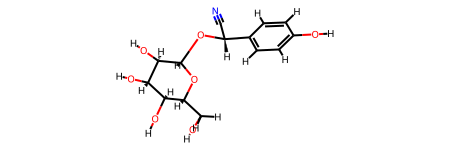

In [48]:
clc_reader_results = get_clc("1e55")
dhurrin_component = clc_reader_results[0].component
dhurrin_component.mol

In [49]:
dhurrin_component.fetch_external_mappings(all_mappings=True)

[('EPA CompTox Dashboard', 'DTXSID90198142'),
 ('ZINC', 'ZINC000004096638'),
 ('SureChEMBL', 'SCHEMBL50174'),
 ('Nikkaji', 'J10.589I'),
 ('ChEBI', '27826'),
 ('KEGG LIGAND', 'C05143'),
 ('eMolecules', '32231621'),
 ('BRENDA', '30532'),
 ('BRENDA', '1121'),
 ('MetaboLights', 'MTBLC27826'),
 ('Rhea', '27826'),
 ('HMDB', 'HMDB0060471'),
 ('PubChem', '161355'),
 ('PubChem TPHARMA', '24422914'),
 ('NMRShiftDB', '60025950'),
 ('fdasrs', 'P5999IY65C')]

Instead of creating the complete representation of fragmented ligands from PDB entries, you can find the standardized IDs of these ligands from [interacting_chains_with_ligand_functions.tsv](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/additional_data/pdb_ligand_interactions/interacting_chains_with_ligand_functions.tsv) available from FTP. The below example shows how this can be done for the entry **1e55**. 

In [50]:
import wget
from pdbeccdutils.core import clc_reader

In [56]:
interacting_chains = os.path.join(PDBECHEM_URL, "additional_data", "pdb_ligand_interactions", "interacting_chains_with_ligand_functions.tsv")
wget.download(interacting_chains)

In [57]:
int_chain_ligand = pd.read_csv("interacting_chains_with_ligand_functions.tsv", sep="\t")
int_chain_ligand.head()

,PDBID,Chain_Symmetry,BestUnpAccession,bmID,inchikey,LigandID,LigandType,annotation
0,100d,A,NaN,bm1,PFNFFQXMRSDOHW-UHFFFAOYSA-N,SPM,CCD,NaN
1,101d,A,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
2,101d,A,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN
3,101d,B,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
4,101d,B,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN


In [58]:
int_chain_ligand[int_chain_ligand["PDBID"]=="1e55"]

,PDBID,Chain_Symmetry,BestUnpAccession,bmID,inchikey,LigandID,LigandType,annotation
15854,1e55,A,P49235,bm1,NVLTYOJHPBMILU-YOVYLDAJSA-N,CLC_000189,CLC,NaN
15855,1e55,B,P49235,bm2,NVLTYOJHPBMILU-YOVYLDAJSA-N,CLC_000189,CLC,NaN


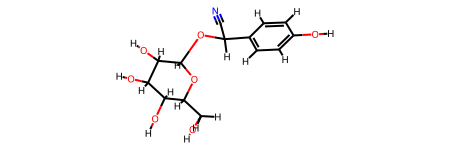

In [59]:
durrin_cif = get_ligand_cif("CLC_000189", ligandType.CLC)
dhurrin_cif_component = clc_reader.read_clc_cif_file(durrin_cif).component
dhurrin_cif_component.mol

### Highlighting CCDs present in a Covalently Linked Component (CLC)

In [60]:
pubchem_downloader.process_template(dhurrin_cif_component)
depictions = DepictionManager(pubchem_templates)
depiction_result = dhurrin_cif_component.compute_2d(depictions)
depiction_result

[18:48:31] unrecognized bond type[18:48:31] unrecognized bond type[19:01:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


DepictionResult(source=<DepictionSource.PubChem: 1>, template_name='CLC_000189', mol=<rdkit.Chem.rdchem.Mol object at 0x7fc8c16dab20>, score=0.0)

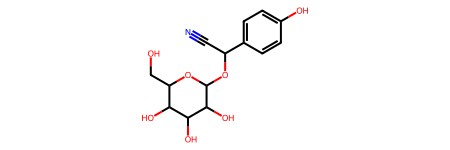

In [61]:
dhurrin_cif_component.mol2D

In [62]:
dhurrin_subcomponents = get_subcomponents(dhurrin_cif_component)
dhurrin_subcomponents

[Subcomponent(id='1', name='BGC', atoms=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11']),
 Subcomponent(id='2', name='DHR', atoms=['N12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'O20', 'C21'])]

In [63]:
subcomponent_colors = [(0.0, 0.0, 1.0, 0.5), (1.0, 0.0, 0.0, 0.5)]
athighlights ={}
bndhighlights = {}
for i, subcomponent in enumerate(dhurrin_subcomponents):
    for atom in subcomponent.atoms:
        athighlights[atom] = subcomponent_colors[i]
    for bond in dhurrin_cif_component.mol.GetBonds():
        bgn_atom = bond.GetBeginAtom().GetProp("name")
        end_atom = bond.GetEndAtom().GetProp("name")
        if bgn_atom in subcomponent.atoms and end_atom in subcomponent.atoms:
            bndhighlights[(bgn_atom, end_atom)] = subcomponent_colors[i]

In [64]:
dhurrin_cif_component.export_2d_svg("dhurrin_ccd.svg", atom_highlight=athighlights, bond_highlight=bndhighlights)

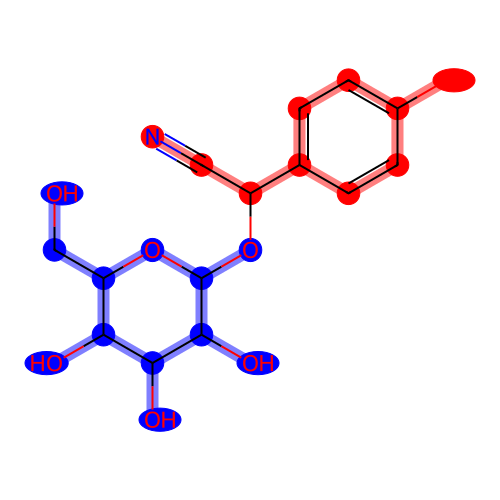

In [65]:
SVG("dhurrin_ccd.svg")

## Analysis of Drug-like molecules in PDB

In [66]:
drug_like_molecules = int_chain_ligand.loc[int_chain_ligand["annotation"]=="drug-like", "LigandID"].unique()
drug_like_molecules

array(['BME', 'MES', 'SAH', ..., 'G3D', 'IYJ', '6UB'], dtype=object)

In [67]:
ccd_component_cif = os.path.join(PDBECHEM_URL, "ccd", "components.cif")
wget.download(ccd_component_cif)

In [69]:
ccd_components = ccd_reader.read_pdb_components_file("components.cif")

In [70]:
import matplotlib.pyplot as plt
import numpy as np

In [71]:
#Filter based on number of atoms
drug_like_with_heavy_atoms = []
for ccd in drug_like_molecules:
    num_heavy_atoms = ccd_components[ccd].component.physchem_properties.get("NumHeavyAtoms", 0)
    if num_heavy_atoms > 6:
        drug_like_with_heavy_atoms.append(ccd)


In [72]:
drug_like_weights = []
for ccd in drug_like_with_heavy_atoms:
    if "exactmw" in ccd_components[ccd].component.physchem_properties:
        drug_like_weights.append(ccd_components[ccd].component.physchem_properties["exactmw"])

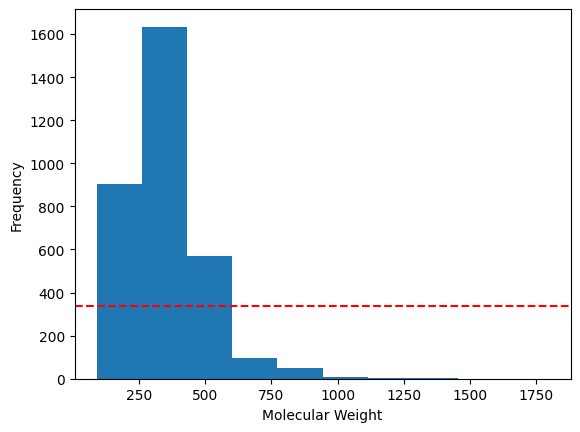

In [73]:
meidan_weight = np.median(drug_like_weights)
plt.hist(drug_like_weights)
plt.axhline(y=meidan_weight, color='r', linestyle='--')
plt.xlabel("Molecular Weight")
plt.ylabel("Frequency")
plt.show()